In [ ]:
import torch

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15756, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15756 (delta 1), reused 11 (delta 1), pack-reused 15743 (from 1)
Receiving objects: 100% (15756/15756), 6.32 MiB | 22.33 MiB/s, done.
Resolving deltas: 100% (11497/11497), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your env

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
import torch

# Load the config
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/Irrigation_Channel_Anomolies/irrigation_config.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Irrigation_Channel_Anomolies/irrigation_model_weights.pth"  # path to the saved model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a threshold for this model

# Initialize the model
predictor = DefaultPredictor(cfg)

# for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
#     image = cv2.imread(d["file_name"])

image=cv2.imread("/content/drive/MyDrive/Irrigation_Channel_Anomolies/training/IMG-20240821-WA0006.jpg")

# Now you can use `predictor` for inference on new images
outputs = predictor(image)  # `image` should be a NumPy array, BGR format as used by OpenCV

print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

# v = Visualizer(image[:, :, ::-1],
#                    metadata=val_metadata,
#                    scale=0.5,
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
#     )
# out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])

[08/21 11:35:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Irrigation_Channel_Anomolies/irrigation_model_weights.pth ...
tensor([2, 3, 0, 3, 1], device='cuda:0')
Boxes(tensor([[  68.6772,  771.9069,  289.3378, 1070.7783],
        [ 777.6128,  620.0869, 1068.3285,  793.7830],
        [  47.5138,  152.5264,  434.3246,  426.8710],
        [ 560.8481,  622.6948,  964.4374,  914.6572],
        [ 547.7552,  104.9780, 1069.8324,  533.6605]], device='cuda:0'))


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/Irrigation_Channel_Anomolies/training/labels_my-project-name_2024-08-21-03-59-05.json", "/content/drive/MyDrive/Irrigation_Channel_Anomolies/training")

In [ ]:
train_metadata = MetadataCatalog.get("my_dataset_train")

In [ ]:
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

[08/21 11:53:27 d2.data.datasets.coco]: Loaded 12 images in COCO format from /content/drive/MyDrive/Irrigation_Channel_Anomolies/training/labels_my-project-name_2024-08-21-03-59-05.json


In [ ]:
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

In [ ]:
metadata

namespace(name='my_dataset_train',
          json_file='/content/drive/MyDrive/Irrigation_Channel_Anomolies/training/labels_my-project-name_2024-08-21-03-59-05.json',
          image_root='/content/drive/MyDrive/Irrigation_Channel_Anomolies/training',
          evaluator_type='coco',
          thing_classes=['Blockage', 'Waste_dumpage', 'Erosion', 'Vegetation'],
          thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3})

In [ ]:
from matplotlib import pyplot as plt

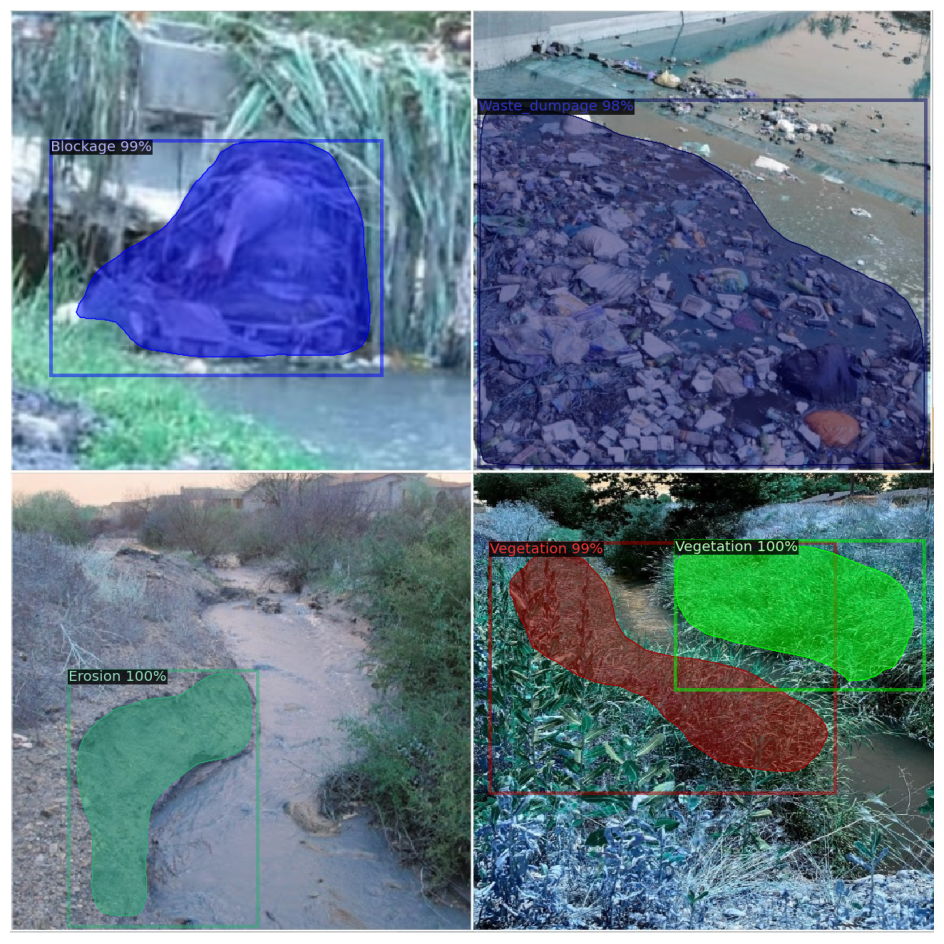

In [ ]:
visualizer = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.2)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))

# Convert the visualized image back to RGB (from BGR) for displaying with matplotlib
visualized_image = out.get_image()[:, :, ::-1]

# Plot the image
plt.figure(figsize=(12, 12))
plt.imshow(visualized_image)
plt.axis("off")
plt.show()